### 1. 주제

- 신용카드 사용자 데이터를 보고 사용자의 대금 연체 정도를 예측

### 2. 배경

- 신용카드사는 신청자의 개인정보와 데이터를 활용해 신용 점수 산정. 이를 이용해 채무 불이행/신용카드 대급 연체 가능성 예측
- 이를 인공지능을 통해 해결해보자

### 3. 대회 설명

- 신용카드 사용자들의 개인 정보를 활용해 신용카드 대금 연체 정도를 예측

### 4. 평가

 - 심사 기준 : Logloss
 - 1차 평가(Public Score) : 테스트 데이터 중 랜덤 샘플된 50%로 채점
 - 2차 평가(Private Score) : 나머지 50%로 채점
 
## [Private 1위]|소회의실|Catboost
 
 logloss를 크게 낮출 수 있었던 요소 -> ID 변수 생성과 catboost 모델 이용 <br/> 랜덤포레스트, LGBM 등 다른 모델과 여러 기법을 시도했지만 catboost가 가장 좋았음
 
### 분석하면서 생각한 핵심 포인트
 - train['family_size'] > 7인 이상치 제거
 - 중복 데이터 처리를 위해 개인정보를 모두 합쳐 ID 변수 생성 (단, 같은 사용자가 여러번 카드를 발급할 수 있으므로 begin_month는 개인정보에서 제외)
 - 개인의 특성이 될 만한 파생변수 추가
 - catboost 모델 사용

In [1]:
!pip install catboost
!pip install category_encoders

In [2]:
# 라이브러리 구성

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [3]:
# 데이터 불러오기

path = './data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [4]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [5]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          10000 non-null  int64  
 1   gender         10000 non-null  object 
 2   car            10000 non-null  object 
 3   reality        10000 non-null  object 
 4   child_num      10000 non-null  int64  
 5   income_total   10000 non-null  float64
 6   income_type    10000 non-null  object 
 7   edu_type       10000 non-null  object 
 8   family_type    10000 non-null  object 
 9   house_type     10000 non-null  object 
 10  DAYS_BIRTH     10000 non-null  int64  
 11  DAYS_EMPLOYED  10000 non-null  int64  
 12  FLAG_MOBIL     10000 non-null  int64  
 13  work_phone     10000 non-null  int64  
 14  phone          10000 non-null  int64  
 15  email          10000 non-null  int64  
 16  occyp_type     6848 non-null   object 
 17  family_size    10000 non-null  float64
 18  begin_m

In [9]:
# 데이터 전처리
# 1. 결축치 처리
train.fillna('NaN', inplace=True) 
test.fillna('NaN', inplace=True)

(0.0, 21.0)

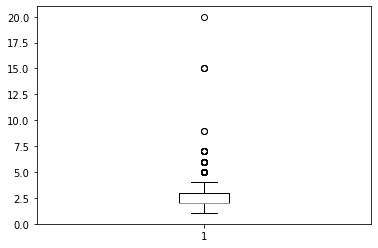

In [12]:
plt.boxplot([train['family_size']])
plt.ylim(0, 21)

In [13]:
# 2. 이상치 처리
# train['family_size'] > 7인 데이터 제거

train = train[train['family_size'] <= 7]
train = train.reset_index(drop=True)

(0.0, 21.0)

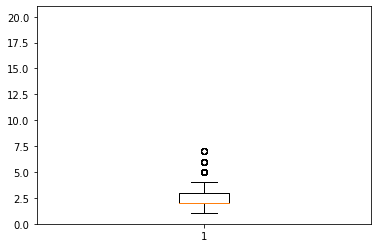

In [14]:
plt.boxplot([train['family_size']])
plt.ylim(0, 21)

In [16]:
# feature engineering
# 1. 의미없는 변수 제거
# index 제거, FlAG_MOBIL 삭제 : 모든 값이 1로 동일

train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

In [21]:
# 2. DAY_EMPLOYED
# 양수인 데이터는 현재 무직자로 판단, 0 처리
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

In [22]:
# 3. DAYS_BIRTH, begin_month, DAYS_EMPLOYED
# 음수 => 양수 변환

feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

In [23]:
# 4. 파생변수
# numeric 변수는 최대한 다양한 특징을 보일 수 있도록 생성
# category 변수는 여러가지를 조합해 보았지만 전체 변수를 합친 ID 하나만 만들었을 때 가장 logloss가 낮음

for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [24]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,...,0.0,38,7.0,1.0,12,0.0,0.0,10.882416,101250.0,0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,...,1.0,31,7.0,1.0,4,3.0,0.0,19.156347,82500.0,1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,...,1.0,52,0.0,2.0,12,3.0,1.0,19.131840,225000.0,0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,...,0.0,41,10.0,3.0,5,9.0,2.0,11.786962,101250.0,0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,...,3.0,41,9.0,0.0,5,10.0,0.0,9.187959,78750.0,0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...


#### 다중공선성
- 공선성(collinearity) : 하나의 독립 변수가 다른 하나의 독립 변수로 잘 예측이 되는 경우, 도는 서로 상관이 높은 경우
- 다중공선성(multicollinearity) : 하나의 독립 변수가 다른 여러 개의 독립 변수들로 잘 예측되는 경우
- (다중)공선성이 있으면 :
    - 계수 추정이 잘 되지 않거나 불안정해져서 데이터가 약간만 바뀌어도 추정치가 크게 달라질 수 있다.
    - 계수가 통계적으로 유의미하지 않은 것처럼 나올 수 있다.
- (다중)공선성의 진단
    - 분산팽창계수(VIF, Variance Inflation factor)를 구하여 판단
    - 엄밀한 기준은 없으나 보통 10보다 크면 다중공선성이 있다고 판단 (5를 기준으로 하기도 함)
    
https://mindscale.kr/course/basic-stat-python/13/

In [25]:
# 5. 파생변수와 다중공선을 보이는 칼럼 삭제
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [26]:
# Scaling, Encoding
# 1. Numeric, Category 컬럼 분류

numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  18
Number of Categorical features:  9


In [27]:
numerical_feats

['income_total',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'before_EMPLOYED',
 'income_total_befofeEMP_ratio',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'Age',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'DAYS_EMPLOYED_w',
 'ability',
 'income_mean']

In [28]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

(array([1.6209e+04, 8.3270e+03, 1.5300e+03, 2.0600e+02, 1.2100e+02,
        4.4000e+01, 3.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00]),
 array([  27000.,  181800.,  336600.,  491400.,  646200.,  801000.,
         955800., 1110600., 1265400., 1420200., 1575000.]),
 <a list of 10 Patch objects>)

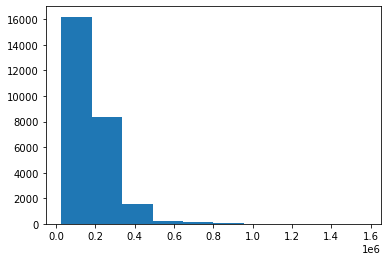

In [29]:
plt.hist(train['income_total'])

In [30]:
# 2. Log Scale
# income_total

for df in [train, test] :
    df['income_total'] = np.log1p(1+df['income_total'])

In [31]:
# 3. OrdinalEncoder
# 카테고리 변수는 ordinal_encoder 변환
# ID는 변환 후 정수 처리

encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')